# Context
Data processing associated with [Stefan's data collection](https://egnyte.nhgh.org/app/index.do#storage/files/1/Shared/Projects/Pediatric%20Pulse%20ROxi/alg%20development/Bench%20data%20for%20Nigeria%20study/Aug1/Stefan) done on Aug 9, 2023, where the goal is to characterise the accelerometers used in the bench study.

`timestamps.xlsx` is a manually annotated file with timestamp information corresponding to the data collection.

[Notes on Confluence](https://nhgh.atlassian.net/wiki/spaces/PSP/pages/1450115097/Accelerometer+Pressure+Sensor+Testing)
## Experiment Assumptions
Natural breathing is assumed (~14 breaths per minute for this adult male subject). RR algorithm evaluation uses seed as 20 breaths per minute to minimize the effect of the seed. Otherwise, setting the seed to 15 breaths per minute results in better than expected performance.

## Parameters
* Background (no movement)
* small movement, pressing on sensor (pressure changes)
* large movement of fingers
  

## Equipment Used
* BMA
* Biopac


In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from ppg2rr import signal_quality as sqi
from ppg2rr import util, riv_est
from ppg2rr.rr_est import estimate_rr_single_frame

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
exp_directory = '../data/bench/20230809 Accel exp/'

# Load Data & Time-Sync

In [4]:

# manual annotations with timings and parameters
timing_df = pd.read_excel(f'{exp_directory}/timestamps.xlsx')
timing_df = timing_df[['Run','Start BMA','End BMA','Note']]
timing_df['duration'] = timing_df['End BMA']-timing_df['Start BMA']

In [5]:
timing_df

Run  Start BMA  End BMA                       Note  duration
0    0       59.0     79.0                 Background      20.0
1    1      102.0    153.0             small movement      51.0
2    2      158.0    175.0              press on palm      17.0
3    3      177.0    189.0             press on thumb      12.0
4    4      197.0    206.0               Finger flick       9.0
5    5      252.0    278.0                 Background      26.0
6    6      297.0    314.0             small movement      17.0
7    7      319.0    340.0              press on palm      21.0
8    8      349.0    368.0  press on thumb and wiggle      19.0
9    9      369.0    378.0               Finger flick       9.0

## NH Custom Hardware

In [6]:
df = pd.read_csv(f'{exp_directory}/BMA400_2023-08-09_15-05-22.csv')
df['ppg'] = -df['ppg'] # flip ppg direction to get the appropriate shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99494 entries, 0 to 99493
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ppg_counter           99494 non-null  int64  
 1   ppg_us                99494 non-null  int64  
 2   ppg_agc_stable        99494 non-null  int64  
 3   ppg_led_drive_levels  99494 non-null  int64  
 4   ppg                   99494 non-null  int64  
 5   ppg_in_waiting        99494 non-null  int64  
 6   x1                    99494 non-null  float64
 7   y1                    99494 non-null  float64
 8   z1                    99494 non-null  float64
 9   x2                    99494 non-null  float64
 10  y2                    99494 non-null  float64
 11  z2                    99494 non-null  float64
 12  force                 99494 non-null  float64
 13  ser1.in_waiting       99494 non-null  int64  
 14  pressure              99494 non-null  float64
 15  pressure_clock_ms  

In [7]:
# add timestamp info to the main data file
df = df.assign(run=None,note=None)
for idx, row in timing_df.iterrows():
    selector = df['elapsed_time_ms'].between(row['Start BMA']*1000,row['End BMA']*1000) 
    df.loc[selector,'run'] =  row['Run']
    df.loc[selector,'note'] = row['Note']


# datetime is estimated using the filename
df['datetime'] = pd.to_datetime('2023-08-09 15:05:22') + pd.to_timedelta(df['elapsed_time_ms'], unit='ms')

In [8]:
df = df.fillna(np.nan)
df.sample(10)

ppg_counter      ppg_us  ppg_agc_stable  ppg_led_drive_levels     ppg   
7493         28518  4102563813               1                    25 -284916  \
98842        54331   172974557               1                    25 -252489   
1558         22583  4078824980               1                    25 -338515   
63802        19291    32821444               1                    25 -327743   
68620        24109    52092497               1                    25 -286047   
50546         6035  4274767347               1                    25 -365007   
68102        23591    50020599               1                    25 -289657   
84424        39913   115305390               1                    25 -287374   
78208        33697    90442612               1                    25 -297327   
57125        12614     6114757               1                    25 -389284   

       ppg_in_waiting     x1     y1     z1     x2  ...     z2  force   
7493                0 -0.777  0.379  0.403 -0.132  ... -0.083   15.0  \
98842               0 -0.824  0.484  0.027  0.022  ...  0.946    5.0   
1558               30 -0.749  0.441  0.416 -0.069  ... -0.117   24.0   
63802               0 -0.770  0.371  0.448  0.068  ...  0.953    3.0   
68620               0 -0.789  0.335  0.438  0.059  ...  0.950    5.0   
50546               0 -0.557  0.519  0.623 -0.032  ... -0.093    0.0   
68102               0 -0.789  0.335  0.439  0.060  ...  0.951    5.0   
84424               0 -0.452 -0.729 -0.516  0.039  ...  0.948    2.0   
78208               0 -0.115 -0.460 -0.899  0.088  ...  0.949    6.0   
57125               0 -0.599  0.657  0.396  0.044  ... -0.159   15.0   

       ser1.in_waiting  pressure  pressure_clock_ms  ser2.in_waiting   
7493                 0    2.5269              30004                0  \
98842                0    2.5220             395491                0   
1558                 0    2.5220               6263                0   
63802                0    2.5220             255297                0   
68620                0    2.5220             274573                0   
50546                0    2.5220             202261                0   
68102                0    2.5220             272498                0   
84424                0    2.5220             337805                0   
78208                0    2.5220             312935                0   
57125                0    2.5220             228581                0   

       elapsed_time_ms  run           note                   datetime  
7493         31574.643  NaN            NaN 2023-08-09 15:05:53.574643  
98842       396953.060  NaN            NaN 2023-08-09 15:11:58.953060  
1558          7839.825  NaN            NaN 2023-08-09 15:05:29.839825  
63802       256798.728  5.0     Background 2023-08-09 15:09:38.798728  
68620       276069.719  5.0     Background 2023-08-09 15:09:58.069719  
50546       203777.475  4.0   Finger flick 2023-08-09 15:08:45.777475  
68102       273997.822  5.0     Background 2023-08-09 15:09:55.997822  
84424       339282.382  7.0  press on palm 2023-08-09 15:11:01.282382  
78208       314419.882  NaN            NaN 2023-08-09 15:10:36.419882  
57125       230092.114  NaN            NaN 2023-08-09 15:09:12.092114  

[10 rows x 21 columns]

In [9]:
smoothed_pressure = signal.medfilt(df['pressure'],75)
df['smoothed_pressure'] = smoothed_pressure

## Biopac

In [10]:
df_biopac = pd.read_csv(f'{exp_directory}/Stefan Accelerometers Biopac (pulse-accel).txt',header=None, skiprows=15)
fs_biopac = 2000
biopac_labels = ['time (min)','ppg', 'accelX', 'accelY', 'accelZ', 'n/a']
df_biopac.columns = biopac_labels
df_biopac.info()

# Convert minute column to datetime using the "Recording on" information in the .txt file.
biopac_time_start = pd.to_datetime('2023-08-09 15:04:51.245')
df_biopac['datetime'] = biopac_time_start + pd.to_timedelta(df_biopac['time (min)'], unit="minutes")

# drop unused columns; center accel data
df_biopac = df_biopac.drop(columns=['n/a'])
for col in ['accelX', 'accelY', 'accelZ']:
    df_biopac[col] = (df_biopac[col]-np.median(df_biopac[col]))*24
df_biopac.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874520 entries, 0 to 874519
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time (min)  874520 non-null  float64
 1   ppg         874520 non-null  float64
 2   accelX      874520 non-null  float64
 3   accelY      874520 non-null  float64
 4   accelZ      874520 non-null  float64
 5   n/a         0 non-null       float64
dtypes: float64(6)
memory usage: 40.0 MB


time (min)       ppg   accelX    accelY     accelZ   
0    0.000000 -0.002422  6.23496  7.962744  13.634304  \
1    0.000008 -0.002420  6.23496  7.962744  13.634304   
2    0.000017 -0.002422  6.23496  7.962744  13.596744   
3    0.000025 -0.002422  6.23496  7.962744  13.596744   
4    0.000033 -0.002425  6.27264  7.962744  13.596744   

                       datetime  
0 2023-08-09 15:04:51.245000000  
1 2023-08-09 15:04:51.245499998  
2 2023-08-09 15:04:51.246000002  
3 2023-08-09 15:04:51.246500000  
4 2023-08-09 15:04:51.246999998

In [11]:
# add timestamp info to the main data file, use datetime from the NH hardware
df_biopac = df_biopac.assign(run=None,note=None)
for run in timing_df['Run'].unique():
    subset = (df['run'] == run) 
    biopac_subset = df_biopac['datetime'].between(min(df.loc[subset,'datetime']),max(df.loc[subset,'datetime']))
    df_biopac.loc[biopac_subset,'run'] =  int(run)
    

# Visualize Data

In [12]:
# helper function to visualize data
fs = 250
df.shape[0]/fs/60 #minutes; sense-checking if fs is correct

def make_figure(df_all, target, subset=None, start=None, fs=250, duration=30, legend=True, show=True):
    """
    Args:
        subset: boolean array to select a subset of df_all
        target: target column to display
        start: index to zoom in on, seconds
        fs: sampling frequency, Hz
        duration: together with "start" and "fs", sets the the x axis limit.
        
    Returns:
        ppg array specified with subset
    """

    
    if subset is not None:
        subset = df_all['datetime'].between(
            df_all.loc[subset,'datetime'].iloc[0],
            df_all.loc[subset,'datetime'].iloc[-1]
            )
        df = df_all[subset]
    else:
        df = df_all
        
    if show:
        plt.figure(figsize=(15,5))
        plt.plot(df[target],color="#8870ff", linewidth=0.5)
        runs = timing_df['Run'].unique()
        for run in runs:
            label = timing_df[timing_df['Run']==run]['Note'].iloc[0]
            plt.plot(df[(df['run']==run)][target], label=label)
            # plt.plot(df[(df['run']==run)][target], color='#FF7E00')
            # plt.plot(df[(df['run']==run)][target], color='#03C03C')
            # plt.plot(df[(df['run']==run)][target], color='#B31B1B')
        plt.ylabel(target)

        if legend:
            # legend proxies   
            # plt.plot([], label = 'no motion; normal breathing', color='#1F75FE')
            # plt.plot([], label = 'motion; normal breathing', color='#FF7E00')
            # plt.plot([], label = 'no motion; deep breathing', color='#03C03C')
            # plt.plot([], label = 'motion; deep breathing', color='#B31B1B')

            plt.legend()
        
        if start is not None:
            frame_len = fs*duration
            end = start*fs + frame_len
            plt.xlim(start*fs,end)
            
        
        plt.show()
    
    return df[target]

In [15]:
df['ppg_led_drive_levels'].unique()

array([25])

In [14]:
# use "subset" to view specific runs, or remove the argument to see the entire file
run = 0
subset = (df['run'] == run)
nh_subset = df['datetime'].between(min(df.loc[subset,'datetime']),max(df.loc[subset,'datetime']))
fig = px.line(y=df[nh_subset]['ppg'], title='NH hardware')
fig.show()

subset = (df['run'] == run)
nh_subset = df['datetime'].between(min(df.loc[subset,'datetime']),max(df.loc[subset,'datetime']))
fig = px.line(y=df[nh_subset]['ppg_led_drive_levels'], title='NH hardware')
fig.show()

biopac_subset = (df_biopac['run']==run)
fig = px.line(y=df_biopac[biopac_subset]['ppg'], title='Biopac hardware')
fig.show()

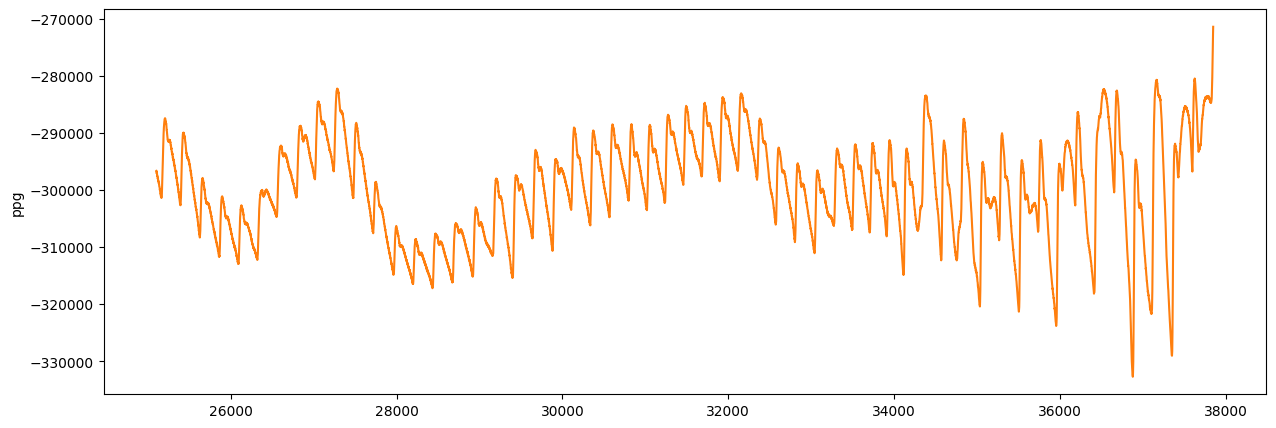

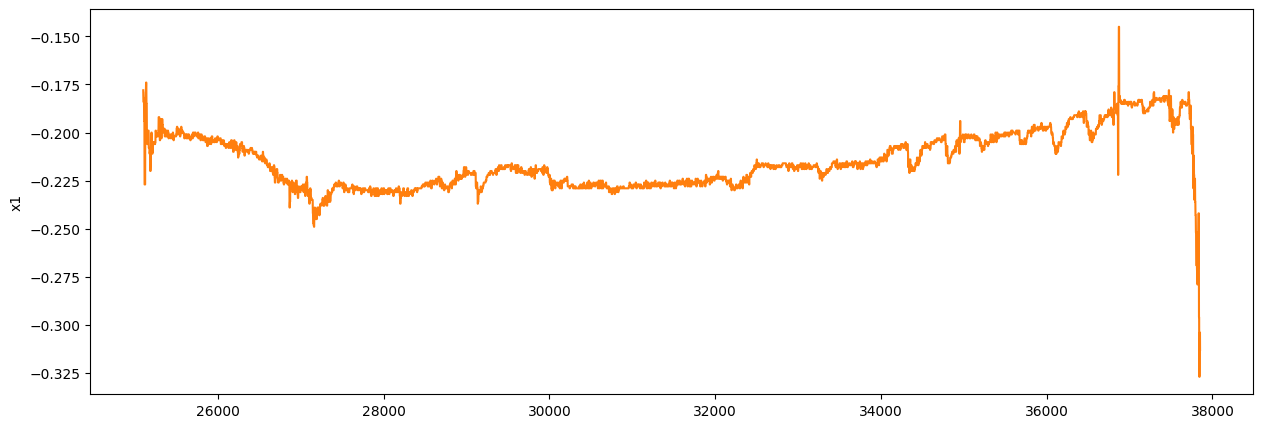

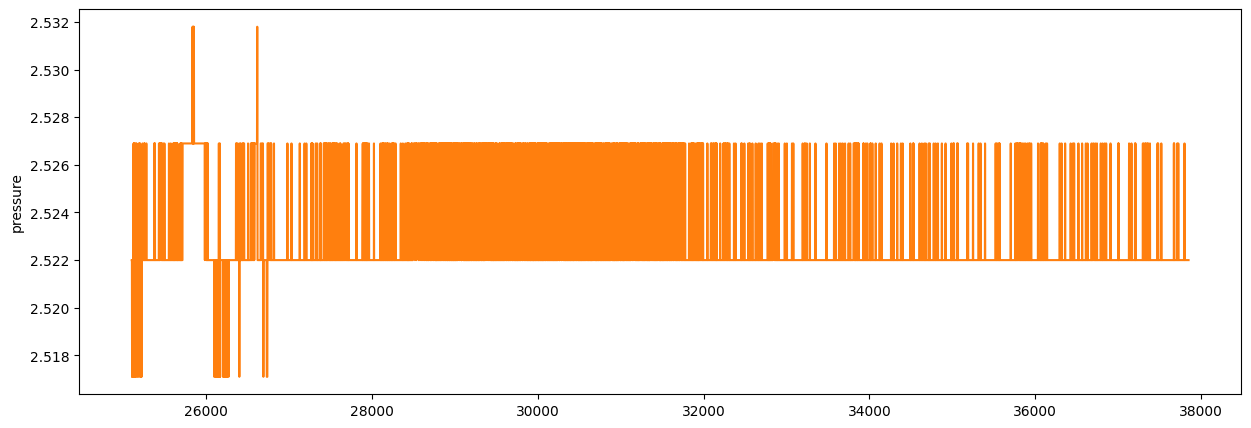

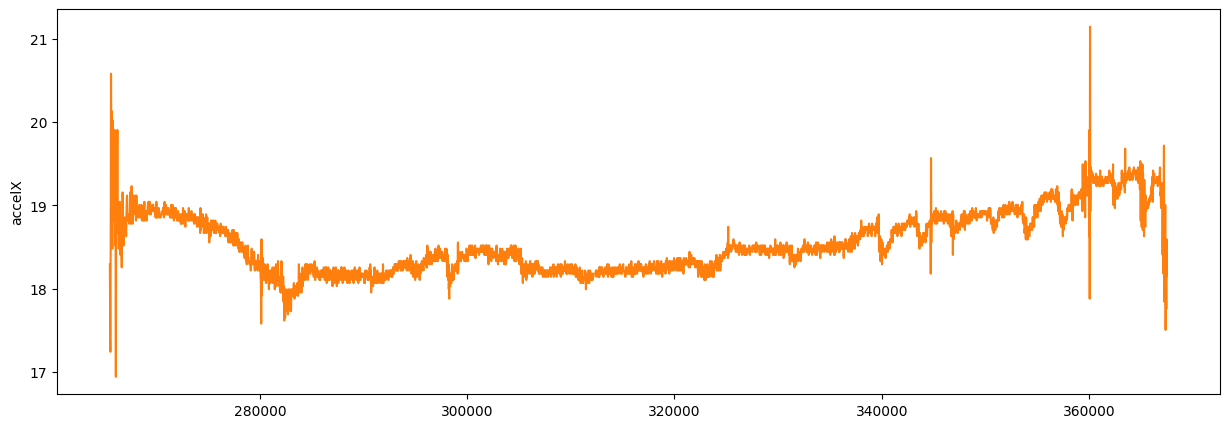

In [14]:
# Phil's hardware 
run = [1]

# adjust start, duration, and subset to view different segments
# start = 30
# subset = None
# duration = 60
subset = (df['run'].isin(run)) # view data from a specific run
start=None
# start=None
duration = 60

ppg_nh = make_figure(df,'ppg',subset=subset,start=start,duration=duration, legend=False)
accel = make_figure(df,'x1',subset=subset,start=start,duration=duration, legend=False)
_ = make_figure(df,'pressure',subset=subset,start=start,duration=duration, legend=False)

subset = (df_biopac['run'].isin(run)) # view data from a specific run
_ = make_figure(df_biopac,'accelX',subset=subset,fs=2000,start=start,duration=duration, legend=False)


## Compare PPG waveforms across 2 devices

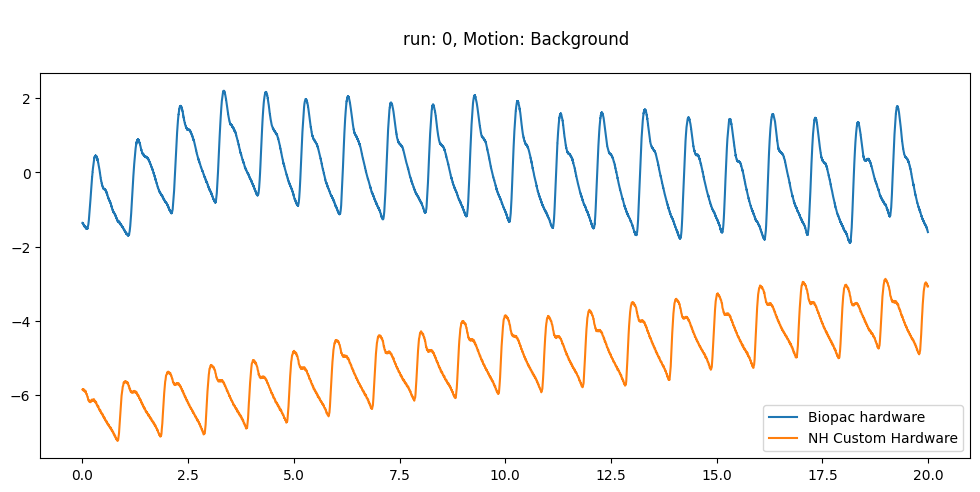

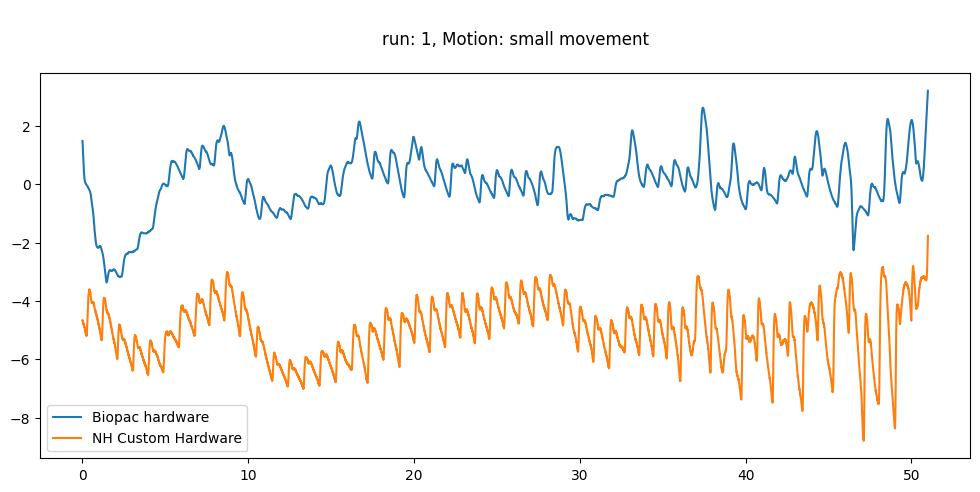

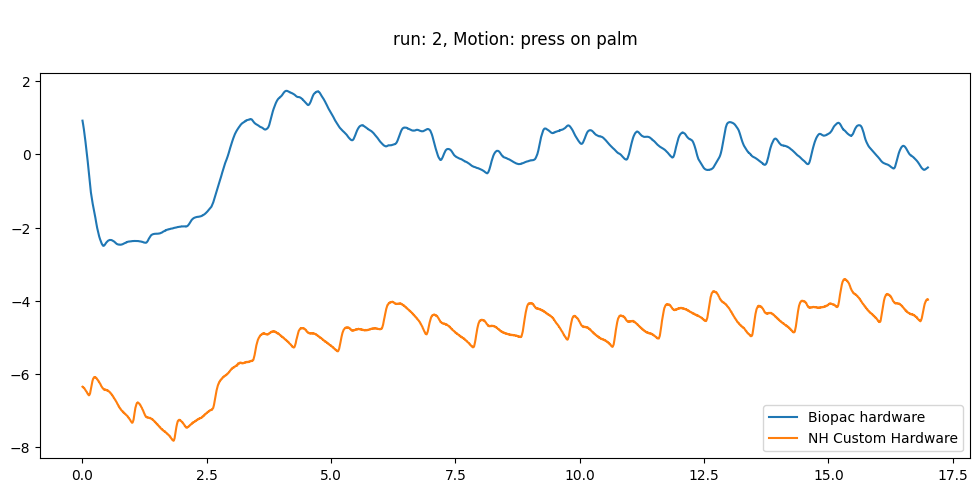

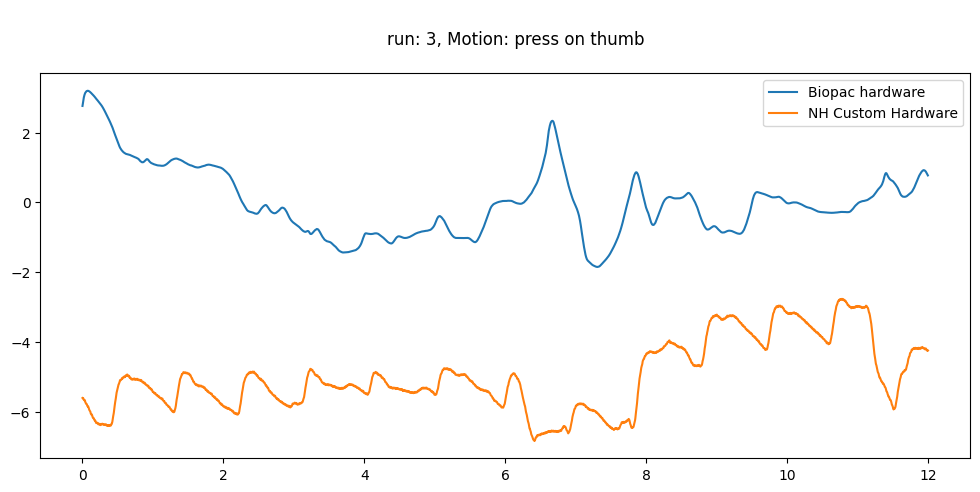

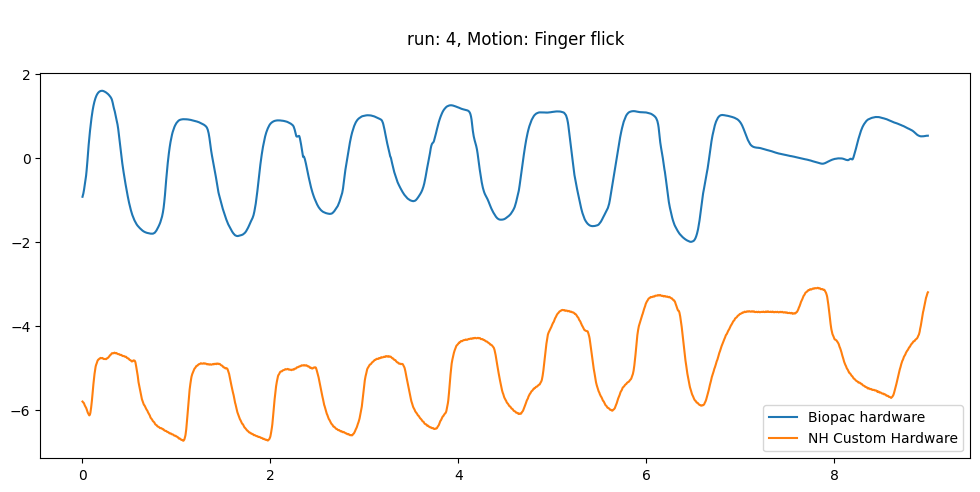

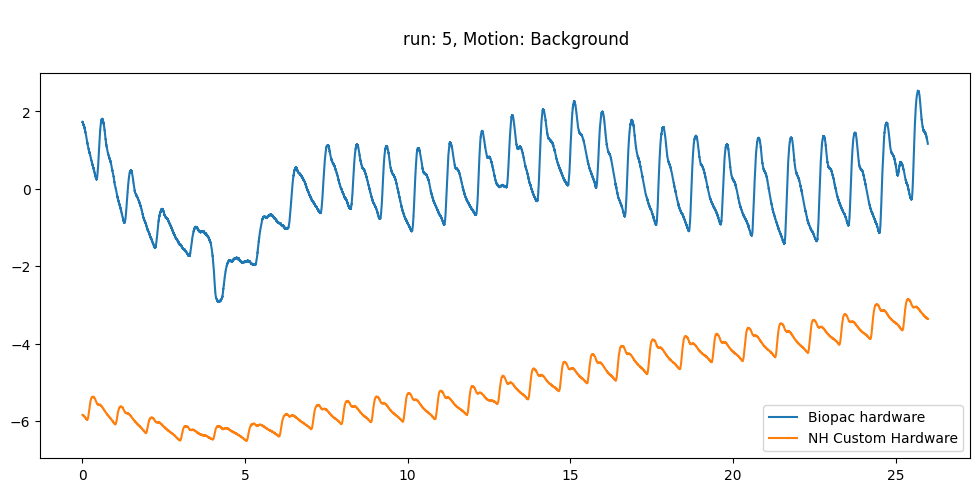

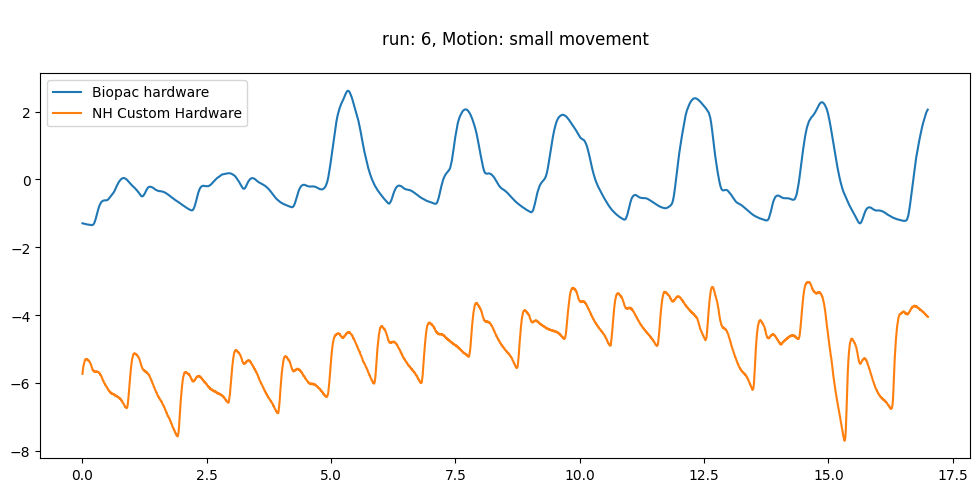

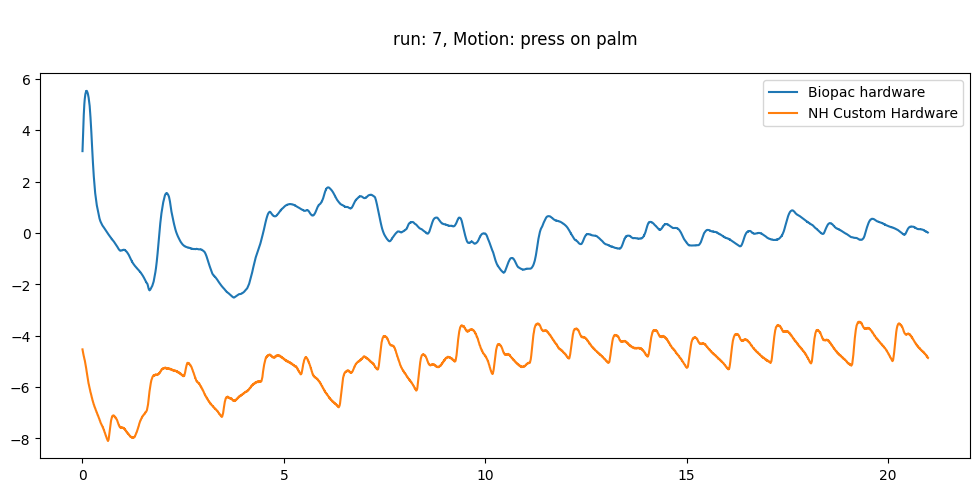

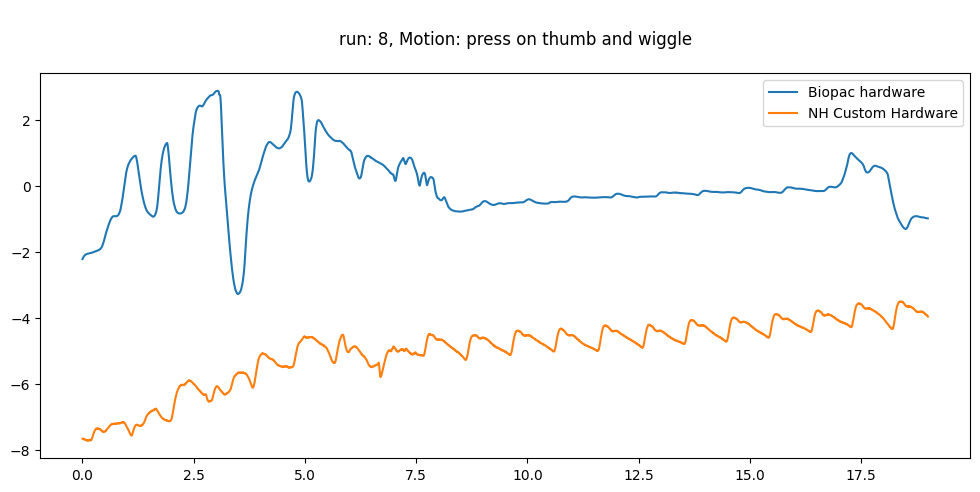

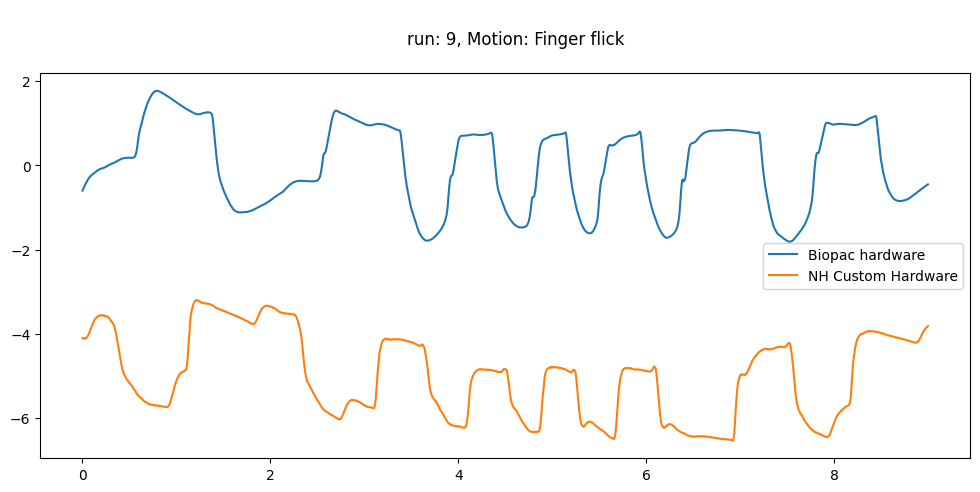

In [37]:
# manually adjust id between 015, 016, and 017, as well as P1 and P2
def standardize(data):
    return (data-np.mean(data))/np.std(data)

runs = np.arange(0,10)
valid_run = []
run_label = []
rr_est1 = []
rr_est2 = []

for run in runs:
    subset = (df['run'] == run)
    biopac_subset = df_biopac['run'] == run

    # make axes and plot figures
    ppg_biopac = df_biopac[biopac_subset]['ppg']
    nh_subset_ppg = df[subset]['ppg']
    
    x_biopac = np.arange(0,len(ppg_biopac))/2000
    x_nh = np.arange(0,len(nh_subset_ppg))/250
    title = f"""
    run: {run}, Motion: {timing_df[timing_df['Run']==run]['Note'].iloc[0]}
    """
    
    plt.figure(figsize=(12,5))
    plt.plot(x_biopac,standardize(ppg_biopac), label = 'Biopac hardware')
    plt.plot(x_nh,standardize(nh_subset_ppg)-5, label = 'NH Custom Hardware')
    plt.title(title)
    plt.legend()
    plt.show()
    
    # Also do RR estimation with algorithm
    labels = ['Biopac','NH Custom']
    ppgs = [ppg_biopac, nh_subset_ppg]
    fss = [2000,250]
    for ppg,fs,label in zip(ppgs,fss,labels):
        # ppg_lp = util.lowpass_butter(ppg,250,5/60)
        # ppg_hp = ppg-ppg_lp
        (
        rr_candidate_merged,
        all_rr_candidates,
        feature_quality,
        ) = estimate_rr_single_frame(
            ppg=ppg,
            fs_ppg=fs,
            hr_est=70,
            rr_max=70/1.75,
            min_resp_freq=4/60,
            rr_est=10,
            remove_riv_outliers=None,
            fs_riv=20,
            n_sig=3,
            show=False,
        )
            
        valid_run.append(run)
        run_label.append(label)
        rr_est1.append(rr_candidate_merged['kalman'])
        rr_est2.append(rr_candidate_merged['simple median'])
                
results_df = pd.DataFrame({
    "run":valid_run,
    "hardware":run_label,
    "kalman est":rr_est1,
    "simple median est": rr_est2,
})

In [39]:
results2 = results_df.pivot(index='run',columns='hardware',values=['kalman est','simple median est'])
results2

kalman est            simple median est          
hardware     Biopac  NH Custom            Biopac NH Custom
run                                                       
0         11.425781  16.406250         14.930000  16.40625
1         12.304688  11.425781         18.750000  13.48000
2         18.164062  21.093750         18.164062  14.94000
3         20.214844  15.820312         19.400000  18.16000
4         21.679688  18.164062         20.215000  18.16000
5         14.941406  11.425781         15.230000  12.89000
6         26.367188  27.246094         17.580000  22.99000
7         20.507812  14.941406         18.415000  19.33000
8         15.820312  19.921875         18.750000  16.41000
9         12.597656  14.355469         15.920000  18.75000

In [36]:
results2.to_csv(f'{exp_directory}/evaluation_results_accel_test_20230814.csv')

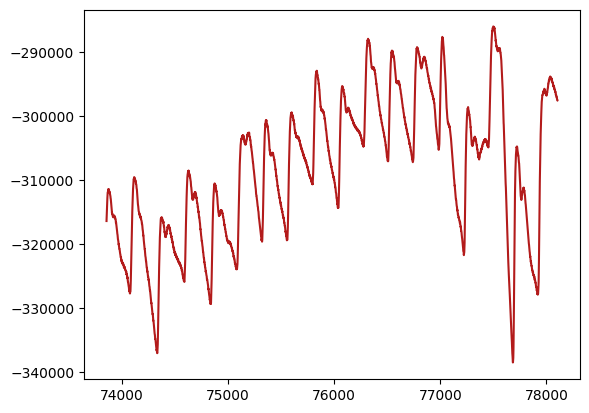

In [46]:
# Manually pull out figures for presentation
subset = (df['run']==6) # view data from a specific run
ppg_nh = make_figure(df,'ppg',subset=subset,legend=False, show=False)
plt.plot(ppg_nh, color="#B31B1B")
# plt.ylim([-.85,-.6])

# Save data if desired
# nh_subset_ppg.to_csv('ppg_example.csv', index=False)

In [16]:
subset = (df['run']==5) # view data from a specific run
ppg_nh = make_figure(df,'ppg',subset=subset,legend=False, show=False)

(
rr_candidate_merged,
all_rr_candidates,
feature_quality,
) = estimate_rr_single_frame(
    ppg=ppg_nh.values,
    fs_ppg=250,
    hr_est=70,
    rr_max=70/1.75,
    min_resp_freq=4/60,
    rr_est=20,
    remove_riv_outliers=None,
    fs_riv=10,
    n_sig=3,
    show=False,
)

rr_candidate_merged

{'PSD, closest to prev RR': 16.99,
 'PSD median': 15.53,
 'Counting, median # peaks': 11.9,
 'simple median': 15.53,
 'kalman': 15.52734375,
 'Counting, median pk delta': 15.13}

# Calculate SNR

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['smoothed_pressure'][5:],color="#8870ff", linewidth=0.5)
for run in df['run'].unique():
    plt.plot(df[df['run']==run]['smoothed_pressure'])
plt.title('raw pressure')
plt.xlim(110000,110000+50*fs)
plt.show()

In [48]:
# calculate SNR
target_signal = 'x1'

def power(arr):
    # power is equivalent to the mean-squared signal
    arr_centered = arr - np.mean(arr) #remove bias first
    squared_arr = np.square(arr_centered)
    return np.mean(squared_arr)

background_runs = df['run'].isin([0,5])
p_noise = power(df[background_runs][target_signal])

selectors = {
    'small motion':df['run'].isin([1,2,3,6,7,8]),
    'large motion':df['run'].isin([4,9]),
}

conditions = []
snrs = []
for condition, selector in selectors.items():
    runs = df[selector]['run'].unique()
    for run in runs:
        isolated_signal = df[selector & (df['run']==run)][target_signal]
        p_signal = power(isolated_signal)
        snr_db = 10*np.log10(p_signal/p_noise)
        
        conditions.append(condition)
        snrs.append(snr_db)

print(f'SNR (dB) for {target_signal}')
snr_df = pd.DataFrame({'condition':conditions,'snr (dB)':snrs})
snr_df.groupby('condition').agg(['mean', 'std'])

SNR (dB) for x1


snr (dB)          
                   mean       std
condition                        
large motion  22.392139  1.271046
small motion   8.220354  5.631667